In [13]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# import slayer from lava-dl
from tqdm import tqdm
from lava.lib.dl.decolle.loss import DECOLLELoss
from lava.lib.dl.decolle.utils import DECOLLEAssistant
import lava 
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
import IPython.display as display
from matplotlib import animation
import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import read_csv

# Multi  MLP Bootstrap TTFS

In [120]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os

# ===========================
# 1. Data Preparation
# ===========================

# Read the CSV file and set 'date' as the index
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
dataset = read_csv('jordan_pv.csv', index_col='date')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index()
dataset = dataset.dropna()
dataset = dataset.astype(np.float64)

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 12, 1)
# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# ===========================
# 2. TTFS Encoding
# ===========================

time_steps = 16  # Define the number of time steps

def ttfs_encoding(batch, max_time_steps):
    """
    TTFS Encoding without epsilon adjustment.
    """
    spike_times = (1.0 - batch) * (max_time_steps - 1)
    spike_times = spike_times.long()
    return spike_times

def generate_ttfs_spike_trains(spike_times, max_time_steps):
    """
    Generate spike trains with spikes at the spike time.
    """
    batch_size, num_features = spike_times.shape
    spike_trains = torch.zeros(batch_size, num_features, max_time_steps)
    for b in range(batch_size):
        for n in range(num_features):
            t = spike_times[b, n]
            if t >= 0 and t < max_time_steps:
                spike_trains[b, n, t] = 1.0  # Spike at time t
    return spike_trains  # Shape: [batch_size, num_features, time_steps]

# Apply TTFS encoding
train_spike_times = ttfs_encoding(train_X, time_steps)
test_spike_times = ttfs_encoding(test_X, time_steps)
train_X_encoded = generate_ttfs_spike_trains(train_spike_times, time_steps)
test_X_encoded = generate_ttfs_spike_trains(test_spike_times, time_steps)

# Reshape and permute to match expected input shape
# Add singleton dimensions for height and width
train_X_encoded = train_X_encoded.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, num_features, time_steps, 1, 1]
test_X_encoded = test_X_encoded.unsqueeze(3).unsqueeze(4)

# Permute dimensions to [batch_size, channels, depth (time), height, width]
train_X_encoded = train_X_encoded.permute(0, 1, 2, 3, 4)
test_X_encoded = test_X_encoded.permute(0, 1, 2, 3, 4)

# ===========================
# 3. Create DataLoaders
# ===========================

batch_size = 64
training_set = torch.utils.data.TensorDataset(train_X_encoded, train_y)
testing_set = torch.utils.data.TensorDataset(test_X_encoded, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=testing_set, batch_size=batch_size, shuffle=False)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, time_steps=time_steps):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold': 0.5,
            'current_decay': 1,  # This must be 1 to use batchnorm
            'voltage_decay': 0.03,
            'tau_grad': 0.1,
            'scale_grad': 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
            # 'dropout': slayer.neuron.Dropout(p=0.2),  # Neuron dropout
        }

        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),  # Enable affine transform at input
            bootstrap.block.cuba.Dense(neuron_params_norm, 72, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, 1),
        ])

    def forward(self, x, mode):
        N, C, D, H, W = x.shape
        x = x.view(N, -1, D)  # Flatten spatial dimensions if necessary
        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        return x

# ===========================
# 5. Instantiate Network, Optimizer, and Scheduler
# ===========================

lr = 0.001  # Learning rate
epochs = 60  # Training epochs
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

for epoch in range(epochs):
    net.train()
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)
        input, label = input.to(device), label.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        label = label.view(-1, 1).to(device)
        loss = F.mse_loss(rate, label)
        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    net.eval()
    with torch.no_grad():
        for i, (input, label) in enumerate(test_loader, 0):
            mode = scheduler.mode(epoch, i, net.training)
            input, label = input.to(device), label.to(device)
            output = net.forward(input, mode)
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            label = label.view(-1, 1)
            loss = F.mse_loss(rate, label.to(device))
            stats.testing.num_samples += len(label)
            stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' ' * len(f'\r[Epoch {epoch+1}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


                                                                                                                                                            
Mode: SNN
[Epoch 1/60]
SNN Testing: loss =     0.06828                          accuracy = 0.00000 
                                                                                                                                                                                           
Mode: SNN
[Epoch 11/60]
SNN Testing: loss =     0.07855 (min =     0.06828)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                                                                           
Mode: SNN
[Epoch 21/60]
SNN Testing: loss =     0.08340 (min =     0.06828)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                       

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 84.5678
Test MAE (Unnormalized): 63.5079


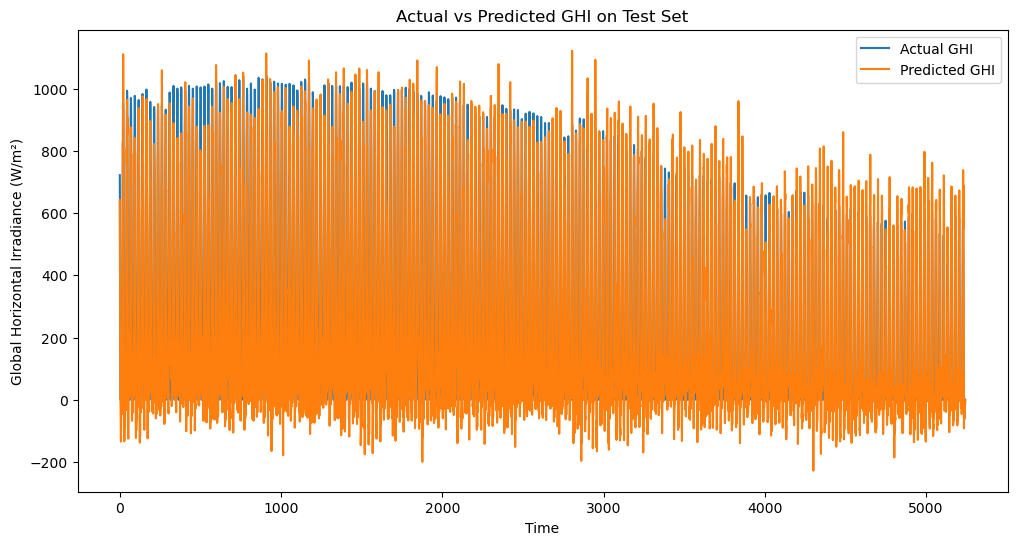

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # If you're evaluating after training, ensure 'epoch' is set appropriately.
    # For example, if you have completed all training epochs, you might set epoch to epochs-1
    # Alternatively, if evaluation is within the training loop, use the current epoch value.
    evaluation_epoch = epochs - 1  # Adjust based on your training loop structure

    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        # Pass False to indicate evaluation phase
        current_mode = scheduler.mode(evaluation_epoch, i, False)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass with the current mode
        output = net(input, mode=current_mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Inverse transform the predictions and actual values
       
        test_predictions_inv = target_scaler.inverse_transform(rate.reshape(-1, 1))
        test_y_inv = target_scaler.inverse_transform(label.numpy().reshape(-1, 1))

        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


# CNN Bootstrap TTFS

# MLP Bootstrap  Sigma Delta

In [122]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os

# ===========================
# 1. Data Preparation
# ===========================

# Read the CSV file, parse the 'date' column with the specified format, and set it as the index
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# Drop rows with missing values
dataset = dataset.dropna()
# Convert all columns to float64
dataset = dataset.astype(np.float64)

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 3, 1)
# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# ===========================
# 2. Sigma-Delta Encoding
# ===========================

time_steps = 16  # Define the number of time steps

def sigma_delta_encoding(batch, time_steps, threshold=0.9):
    """
    Sigma-Delta Encoding: Converts continuous input values into spike trains based on the accumulation of input signals.

    Arguments:
        batch: Tensor of shape [batch_size, num_features]
        time_steps: Number of time steps for encoding
        threshold: Accumulation threshold to emit a spike

    Returns:
        spike_trains: Tensor of shape [batch_size, num_features, 1, 1, time_steps]
    """
    batch_size, num_features = batch.shape
    spike_trains = torch.zeros(batch_size, num_features, 1, 1, time_steps, device=batch.device)
    membrane_potential = torch.zeros(batch_size, num_features, device=batch.device)

    for t in range(time_steps):
        membrane_potential += batch  # Accumulate input
        spikes = (membrane_potential >= threshold).float()
        spike_trains[:, :, 0, 0, t] = spikes  # Assign spikes at current time step
        membrane_potential[spikes.bool()] -= threshold  # Reset membrane potential where spikes occurred

    return spike_trains  # Shape: [batch_size, num_features, 1, 1, time_steps]

def sigma_delta_decoding(output):
    """
    Sigma-Delta Decoding: Decodes the output spike trains into continuous values.

    Arguments:
        output: Tensor of shape [batch_size, 1, 1, 1, time_steps]

    Returns:
        decoded_output: Tensor of shape [batch_size]
    """
    # Sum spikes over the time dimension
    decoded_output = output.sum(dim=-1) / output.size(-1)  # Shape: [batch_size, 1, 1, 1]
    decoded_output = decoded_output.view(output.size(0), -1)  # Shape: [batch_size, 1]
    decoded_output = decoded_output.squeeze(1)  # Shape: [batch_size]
    return decoded_output  # Shape: [batch_size]

# Apply Sigma-Delta encoding
train_X_encoded = sigma_delta_encoding(train_X, time_steps)
test_X_encoded = sigma_delta_encoding(test_X, time_steps)

# ===========================
# 3. Create DataLoaders
# ===========================

batch_size = 64
training_set = torch.utils.data.TensorDataset(train_X_encoded, train_y)
testing_set = torch.utils.data.TensorDataset(test_X_encoded, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch_size, shuffle=False)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, time_steps=time_steps):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold'     : 0.5,
            'current_decay' : 1,  # This must be 1 to use batchnorm
            'voltage_decay' : 0.03,
            'tau_grad'      : 1,
            'scale_grad'    : 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
        }

        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),  # Enable affine transform at input
            bootstrap.block.cuba.Dense(neuron_params_norm, 18, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, 1),
        ])

    def forward(self, x, mode):
        N, C, H, W, T = x.shape
        x = x.reshape(N, -1, T)
        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        return x

# ===========================
# 5. Instantiate Network, Optimizer, and Scheduler
# ===========================

lr     = 0.001  # Learning rate
epochs = 60     # Training epochs
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

for epoch in range(epochs):
    net.train()
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)
        input, label = input.to(device), label.to(device)
        output = net.forward(input, mode)
        # Decode output spikes to continuous values
        decoded_output = sigma_delta_decoding(output)
        label = label.to(device)
        loss = F.mse_loss(decoded_output, label)
        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')
    net.eval()
    with torch.no_grad():
        for i, (input, label) in enumerate(test_loader, 0):
            mode = scheduler.mode(epoch, i, net.training)
            input, label = input.to(device), label.to(device)
            output = net.forward(input, mode)
            decoded_output = sigma_delta_decoding(output)
            label = label.to(device)
            loss = F.mse_loss(decoded_output, label)
            stats.testing.num_samples += len(label)
            stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


                                                                                                                                                            
Mode: SNN
[Epoch 1/60]
SNN Testing: loss =     0.00876                          accuracy = 0.00000 
                                                                                                                                                                                           
Mode: SNN
[Epoch 11/60]
SNN Testing: loss =     0.00593 (min =     0.00876)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                                                                           
Mode: SNN
[Epoch 21/60]
SNN Testing: loss =     0.00453 (min =     0.00593)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                       

Test RMSE (Unnormalized): 46.9529
Test MAE (Unnormalized): 36.0021


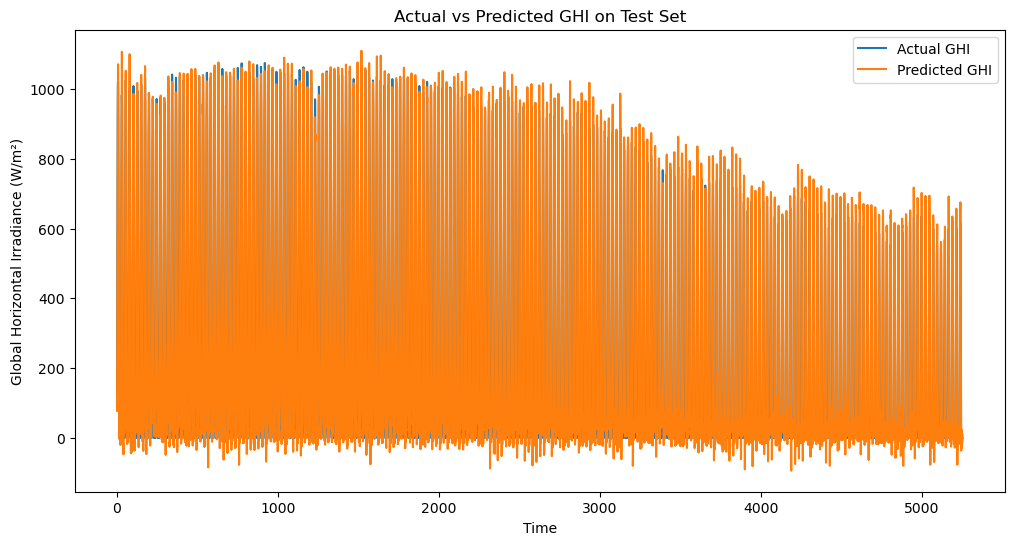

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # If you're evaluating after training, ensure 'epoch' is set appropriately.
    # For example, if you have completed all training epochs, you might set epoch to epochs-1
    # Alternatively, if evaluation is within the training loop, use the current epoch value.
    evaluation_epoch = epochs - 1  # Adjust based on your training loop structure

    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        # Pass False to indicate evaluation phase
        current_mode = scheduler.mode(evaluation_epoch, i, False)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass with the current mode
        output = net(input, mode=current_mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Inverse transform the predictions and actual values
       
        test_predictions_inv = target_scaler.inverse_transform(rate.reshape(-1, 1))
        test_y_inv = target_scaler.inverse_transform(label.numpy().reshape(-1, 1))

        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


# MLP BootStap Population 

In [111]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import joblib  
# ===========================
# 1. Data Preparation
# ===========================
# Read the CSV file, parse the 'date' column with the specified format, and set it as the index
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# Drop rows with missing values
dataset = dataset.dropna()
# Convert all columns to float64
dataset = dataset.astype(np.float64)
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize features
values = dataset.values
# After fitting the scaler and before encoding
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 3, 1)
# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# ===========================
# 2. Population Encoding
# ===========================

time_steps = 16  # Define the number of time steps
num_neurons = 16   # Number of neurons per input feature
threshold_prob = 0.5  # Probability scaling factor
# Load the saved scaler
scaler = joblib.load('scaler.pkl')
def population_encode(data, num_neurons, min_val, max_val, threshold_prob, time_steps):
    """
    Population Encoding with Temporal Dimension: Converts continuous input values into spike trains over multiple time steps.
    """
    batch_size, num_features = data.shape

    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(data.device)  # Shape: [num_neurons]
    sigma = (max_val - min_val) / num_neurons  # Width of the tuning curves

    # Expand dimensions for broadcasting
    data = data.unsqueeze(-1)  # Shape: [batch_size, num_features, 1]
    centers = centers.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, num_neurons]

    # Calculate Gaussian firing rates
    rates = torch.exp(-(data - centers) ** 2 / (2 * sigma ** 2))  # Shape: [batch_size, num_features, num_neurons]

    # Generate spikes over time
    rates = rates.unsqueeze(-1).repeat(1, 1, 1, time_steps)  # Shape: [batch_size, num_features, num_neurons, time_steps]
    spikes = torch.bernoulli(rates * threshold_prob)  # Shape: [batch_size, num_features, num_neurons, time_steps]

    # Reshape to match input shape [batch_size, channels, 1, 1, time_steps]
    # Combine num_features and num_neurons into channels
    spikes = spikes.view(batch_size, num_features * num_neurons, 1, 1, time_steps)

    return spikes

def population_decode(spikes, num_output_neurons, min_val, max_val):
    """
    Population Decoding: Converts spike trains back to continuous values by weighting spikes with their centers.
    """
    # Sum spikes over time
    spikes_sum = spikes.sum(dim=-1)  # Shape: [batch_size, num_output_neurons]

    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_output_neurons).to(spikes.device)  # Shape: [num_output_neurons]

    # Decode by weighting the spikes by their receptive field centers and summing
    decoded_values = (spikes_sum * centers).sum(dim=-1)  # Shape: [batch_size]

    # Normalize by the number of spikes to get the average
    normalization_factor = spikes_sum.sum(dim=-1).clamp(min=1)  # Shape: [batch_size]
    decoded_values /= normalization_factor  # Shape: [batch_size]

    return decoded_values  # Shape: [batch_size]

# ===========================
# 3. Create DataLoaders
# ===========================

batch_size = 64
training_set = torch.utils.data.TensorDataset(train_X_encoded, train_y)
testing_set = torch.utils.data.TensorDataset(test_X_encoded, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch_size, shuffle=False)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, input_channels, num_output_neurons, time_steps=time_steps):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold'     : 0.5,
            'current_decay' : 1,  # This must be 1 to use batchnorm
            'voltage_decay' : 0.03,
            'tau_grad'      : 1,
            'scale_grad'    : 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
        }

        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),  # Enable affine transform at input
            bootstrap.block.cuba.Dense(neuron_params_norm, input_channels, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, num_output_neurons),
        ])

    def forward(self, x, mode):
        N, C, H, W, T = x.shape
        x = x.reshape(N, -1, T)
        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        return x  # Output shape: [batch_size, num_output_neurons, time_steps]

# Set input and output parameters
num_features = train_X.shape[1]
input_channels = num_features * num_neurons
num_output_neurons = 5  # Number of neurons for the output encoding

# ===========================
# 5. Instantiate Network, Optimizer, and Scheduler
# ===========================

lr     = 0.001  # Learning rate
epochs = 60     # Training epochs
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network(input_channels, num_output_neurons).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

for epoch in range(epochs):
    net.train()
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)
        input, label = input.to(device), label.to(device)
        output = net.forward(input, mode)
        # Decode output spikes to continuous values
        decoded_output = population_decode(output, num_output_neurons, min_val, max_val)
        label = label.to(device)
        loss = F.mse_loss(decoded_output, label)
        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')
    net.eval()
    with torch.no_grad():
        for i, (input, label) in enumerate(test_loader, 0):
            mode = scheduler.mode(epoch, i, net.training)
            input, label = input.to(device), label.to(device)
            output = net.forward(input, mode)
            decoded_output = population_decode(output, num_output_neurons, min_val, max_val)
            label = label.to(device)
            loss = F.mse_loss(decoded_output, label)
            stats.testing.num_samples += len(label)
            stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
    print(f'\r[Epoch {epoch+1}/{epochs}] {stats}', end='')
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


                                                                                                                                                            
Mode: SNN
[Epoch 1/60]
SNN Testing: loss =     0.01334                          accuracy = 0.00000 
                                                                                                                                                                                           
Mode: SNN
[Epoch 11/60]
SNN Testing: loss =     0.01650 (min =     0.01334)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                                                                           
Mode: SNN
[Epoch 21/60]
SNN Testing: loss =     0.02427 (min =     0.01334)     accuracy = 0.00000 (max = 0.00000) 
                                                                                                                                       


Test RMSE (Unnormalized): 86.9899
Test MAE (Unnormalized): 19.4088
Test R² Score: 0.7466


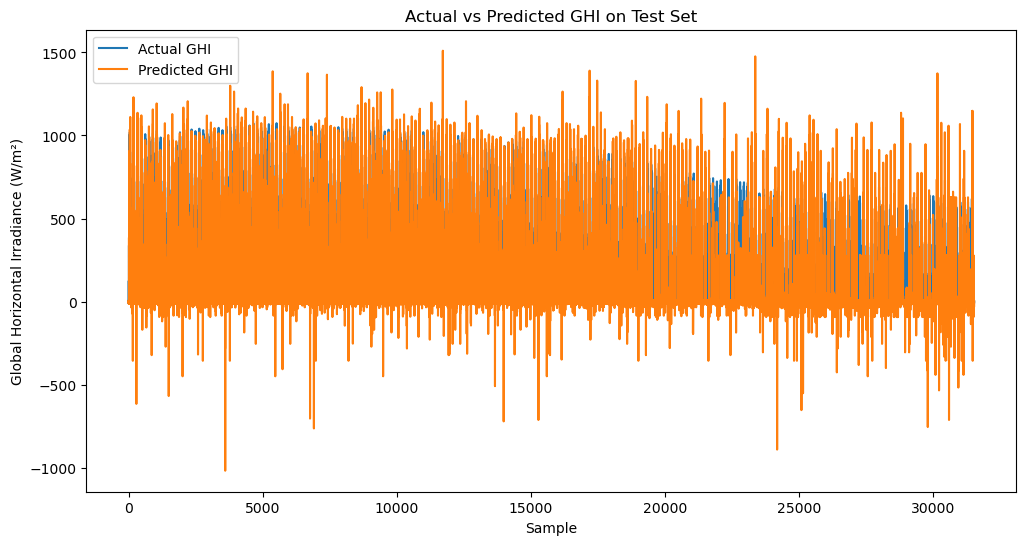

In [112]:

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    evaluation_epoch = epochs - 1  # Assuming the last epoch is for evaluation
    
    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        current_mode = [bootstrap.Mode.SNN] * len(net.blocks)
        
        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)
        
        # Forward pass with the current mode
        output = net.forward(input, current_mode)  # Shape: [batch_size, num_output_neurons, D, H, W]
        
        # Decode output spikes to continuous values
        decoded_output = population_decode(output, num_output_neurons, min_val, max_val)  # Shape: [batch_size]
        
        # Move to CPU and convert to numpy
        decoded_output = decoded_output.cpu().numpy().reshape(-1, 1)  # Shape: [batch_size, 1]
        label = label.cpu().numpy().reshape(-1, 1)  # Shape: [batch_size, 1]
        
        # Inverse transform the predictions and actual values
        # Since scaler was fitted on all features, append zeros to match scaler's expected input shape
        # Assuming the target is the last feature
        num_features = scaler.n_features_in_
        test_predictions_inv = scaler.inverse_transform(np.hstack([
            np.zeros((decoded_output.shape[0], num_features - 1)),
            decoded_output  # Target variable is the last column
        ])).reshape(-1, 1)[:, -1]  # Extract the target column after inverse transform
        
        test_y_inv = scaler.inverse_transform(np.hstack([
            np.zeros((label.shape[0], num_features - 1)),
            label  # Target variable is the last column
        ])).reshape(-1, 1)[:, -1]  # Extract the target column after inverse transform
        
        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate evaluation metrics
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)
test_r2 = r2_score(all_labels, all_predictions)

print(f"\nTest RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Sample')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()
